### This notebook is a working draft of the third lesson / 4th chapter of the fast.ai course ###

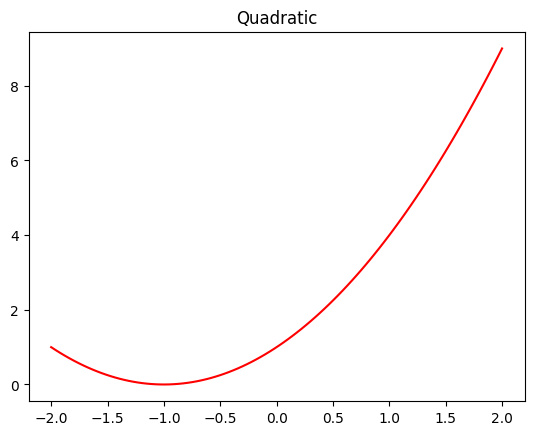

In [4]:
from ipywidgets import interact
from fastai.basics import *

def plot_fn(f, title=None, min=-2, max=2, color='blue', ylim=None):
    x = torch.linspace(min,max,100)[:,None]
    if ylim:
        plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)
    
# plot fn

plot_fn(lambda x: x**2 + 2*x + 1, title='Quadratic', min=-2, max=2, color='red')

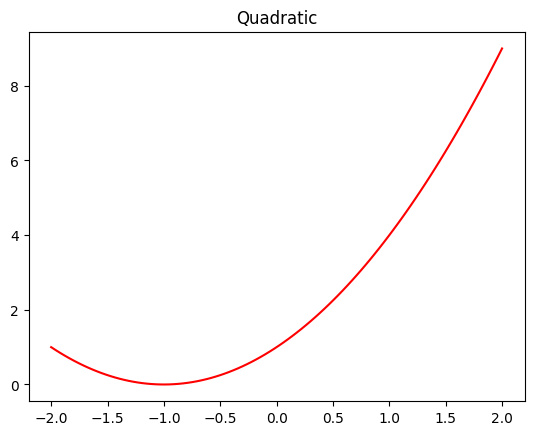

In [16]:
# Creating a quadratic function

def quad(x, a, b, c):
    return a*x**2 + b*x + c

def make_quad(a, b, c):
    return lambda x: quad(x, a, b, c)

# Plotting a quadratic function
f = make_quad(1, 2, 1)
plot_fn(f, title='Quadratic', min=-2, max=2, color='red')


In [55]:
## Adding noise to our quadratic function
import numpy as np

def add_noise(x, noise_strength: int): # This was a simpler implementation of the noise function in the FastAI course (which I found difficult to understand!)
    noise = noise_strength * torch.randn_like(x)
    noisy_x = x + noise
    return noisy_x

np.random.seed(42)

x = torch.linspace(-2,2,steps=20)[:,None]
y = add_noise(f(x), 0.5)

In [56]:
# first values of x and y
x[:5], y[:5]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684],
         [-1.1579]]),
 tensor([[ 0.3524],
         [ 0.7647],
         [ 0.7109],
         [-0.2540],
         [-0.0081]]))

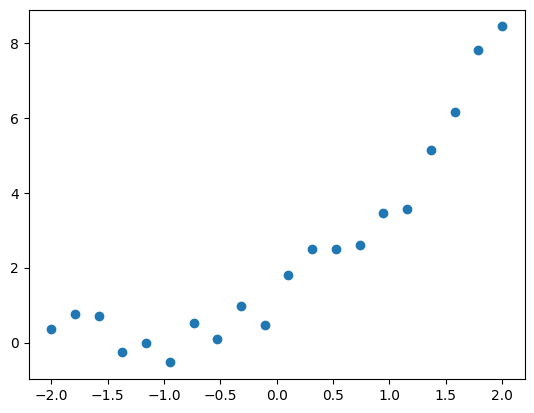

In [62]:
plt.scatter(x, y)

In [58]:
@interact(a=1.1, b=2.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x, y)
    plot_fn(make_quad(a, b, c), min=-2, max=2, color='red', ylim=(-1, 15))

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [59]:
# Defining our Mean Absolute Error function - will be used to determine the loss of our model
def mae(preds, actuals):
    return (torch.abs(preds - actuals)).mean()

In [65]:
# New plot with MAE
@interact(a=1.1, b=2.1, c=1.1)
def plot_quad(a, b, c):
    f = make_quad(a, b, c)
    plt.scatter(x, y)
    loss = mae(f(x), y)
    plot_fn(f, min=-2, max=2, color='red', title = f'MAE: {loss:.2f}', ylim=(-1, 10))


interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

In [67]:
# function that takes all params a, b and c as a single input vector and returns the value mae() based on those params
def quad_mae(*params):
    f = make_quad(*params)
    return mae(f(x), y)

quad_mae(1.1, 2.1, 1.1)

tensor(0.5734)

In [81]:
abc = torch.tensor([1.1, 2.1, 1.1])

In [82]:
abc.requires_grad_() # This is a PyTorch function that tells PyTorch to track the gradients of the tensor

# Calculating the gradient of the loss function with respect to the parameters
loss = quad_mae(*abc)
loss

tensor(0.5734, grad_fn=<MeanBackward0>)

In [83]:
# To calculate the gradient, we call loss.backward()
loss.backward()

# These are now stored for us in an attribute called grad:
abc.grad

tensor([1.1490, 0.2211, 0.5000])

In [84]:
with torch.no_grad(): # This is a PyTorch function that tells PyTorch to ignore the gradients of the tensor
    abc -= abc.grad * 0.02 # This small number is called the 'learning rate' - it determines how much we change the parameters in each iteration (a hyper parameter)
    loss = quad_mae(*abc)

print(f'loss = {loss:.2f}, abc = {abc}')

loss = 0.54, abc = tensor([1.0770, 2.0956, 1.0900], requires_grad=True)


In [88]:
# for looping to do a few iterations

for i in range(100):
    loss = quad_mae(*abc) # calculate loss
    loss.backward() # calculate gradients
    with torch.no_grad():
        abc -= abc.grad * 0.001
        print(f'loss = {loss:.2f}, abc = {abc}', f'iteration: {i}')

loss = 0.46, abc = tensor([1.0154, 1.6962, 1.0796], requires_grad=True) iteration: 0
loss = 0.47, abc = tensor([1.0178, 1.6962, 1.0808], requires_grad=True) iteration: 1
loss = 0.47, abc = tensor([1.0192, 1.6963, 1.0816], requires_grad=True) iteration: 2
loss = 0.47, abc = tensor([1.0195, 1.6966, 1.0820], requires_grad=True) iteration: 3
loss = 0.47, abc = tensor([1.0187, 1.6971, 1.0820], requires_grad=True) iteration: 4
loss = 0.47, abc = tensor([1.0169, 1.6977, 1.0816], requires_grad=True) iteration: 5
loss = 0.47, abc = tensor([1.0140, 1.6985, 1.0808], requires_grad=True) iteration: 6
loss = 0.47, abc = tensor([1.0101, 1.6995, 1.0796], requires_grad=True) iteration: 7
loss = 0.46, abc = tensor([1.0051, 1.7006, 1.0780], requires_grad=True) iteration: 8
loss = 0.46, abc = tensor([0.9991, 1.7019, 1.0760], requires_grad=True) iteration: 9
loss = 0.45, abc = tensor([0.9921, 1.7034, 1.0736], requires_grad=True) iteration: 10
loss = 0.44, abc = tensor([0.9839, 1.7050, 1.0708], requires_gra

### Notes to Self
Gradient descent is at the heart of deep learning. It is the process of minimising a loss function by iteratively updating the weights of a model. A loss function is a measure of how well the model is performing - some common loss functions include MAE and MSE which both calculate the difference between the model outputs (y^) and actual data (y).

In essence, gradient descent is an optimization algorithm. As we compute the gradient of the loss function at each of the model's parameters (e.g. at each point on the loss functions surface), we can see which directions to move to reduce the loss (i.e. minimize the gradient). As gradient -> 0, we have found the minimum of the loss function.

**High level overview of gradient descent process:**
1. Initialize model with random parameters
2. Feed training example (dataset) through the model and compute the difference between the model outputs and the true output (actual data) using the loss function
3. Compute the gradients of the loss function with respect to the model's parameters using backpropogation
4. Update the models' parameters by taking a small step (learning-rate hyperparameter) in the opposite direction to the gradient
5. Repeat steps 2 - 4 for all training examples in the dataset (i.e. all points) for a fixed number of epochs or until convergence

Overtime, the process above will fit the model to the actual data and loss should tend to 0 if the model function is flexible enough to 'mimic' plot of the actual data. Overfitting can occur if the model is too flexible and captures 'noise' in the data rather than the underlying relationship between variables. In this case, the loss may decrease initially on the tradining dataset but then increase again on new, unseen data. Will need to learn more about overfitting and methods to avoid/monitor this.

### How a neural network approximates a given function

A neural network can approximate any computible function, given enough parameters. Two keys step to a NN:
1. Matrix multiplication
2. `max(x,0)` written as np.clip(x,0): replace all negative numbers with zero

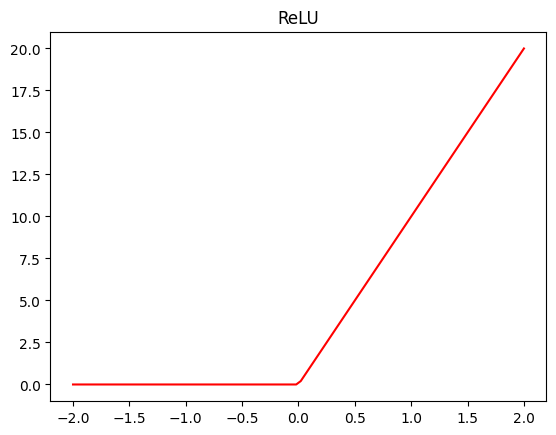

In [94]:
def rectified_linear(x, b, m): # A rectified linear function: a linear function that is clipped at 0
    y = m*x + b
    return torch.clip(y, 0, None)

plot_fn(partial(rectified_linear, b=0, m=10), title='ReLU', min=-2, max=2, color='red')

In [98]:
import torch.nn.functional as F
def relu(x, b, m):
    return F.relu(m*x + b) # This is the same as the rectified_linear function above

In [97]:
@interact(b=(-2,2), m=(0,10))
def plot_relu(m, b):
    plot_fn(partial(relu, b=b, m=m), title='ReLU', min=-2, max=2, color='red')

interactive(children=(IntSlider(value=5, description='m', max=10), IntSlider(value=0, description='b', max=2, …

In [105]:
# adding two ReLUs together
def double_relu(m1, b1, m2, b2, x):
    return relu(x, b1, m1) + relu(x, b2, m2)

@interact(m1=-1.5, b1=0.5, m2=1.5, b2=0.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_fn(partial(double_relu, m1, b1, m2, b2), title='Double ReLU', min=-2, max=2, color='red')

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=0.5, des…

This double ReLu is the foundation of all deep-learning. As we had an infinite number of rectified linear functions together, we can approximate (fit) any computible function - Wow!

Nice example of this is the owl image below. Given enough time + data, we can create an owl recognizer, if we feed enough pictures of owls / non-owls into a model that follows the steps above.

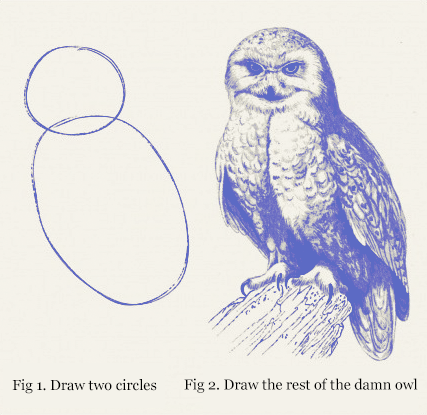